In [1]:
import numpy as np
import matplotlib.pyplot as plt
import trimesh
from trimesh.viewer import SceneViewer
import pyrender
import pyglet
import h5py
import PIL
from data_def import PCAModel, Mesh
from ipywidgets import *

import dlib


In [2]:
fland = np.loadtxt("Landmarks68_model2017-1_face12_nomouth.anl", dtype=int)
bfm = h5py.File("Data/model2017-1_face12_nomouth.h5", 'r')
triangles = np.asarray(bfm['shape/representer/cells'], dtype=np.int32).T
mean_tex = np.asarray(bfm['color/model/mean'], dtype=np.float32).reshape((-1, 3))

# Mean shape and PCA data
mean_shape = np.asarray(bfm['shape/model/mean'], dtype=np.float32).reshape((-1, 3))
mean_shape_fland = mean_shape[fland]
sigma2_shape = np.asarray(bfm['shape/model/pcaVariance'])[:30]
basis_shape = np.asarray(bfm['shape/model/pcaBasis']).reshape((-1, 3, 199))[:, :, :30]
basis_shape_fland = basis_shape[fland]

mean_expr = np.asarray(bfm['expression/model/mean']).reshape((-1, 3))
mean_expr_fland = mean_expr[fland]
sigma2_expr = np.asarray(bfm['expression/model/pcaVariance'])[:20]
basis_expr = np.asarray(bfm['expression/model/pcaBasis']).reshape((-1, 3, 100))[:, :, :20]
basis_expr_fland = basis_expr[fland]

In [9]:
print(mean_shape.shape)
print(sigma2_shape.shape)
print(basis_shape.shape)

print(mean_shape)

(28588, 3)
(30,)
(28588, 3, 30)
[[-57.355762  43.873634  81.17785 ]
 [-57.329094  43.623566  81.15951 ]
 [-57.29688   43.3735    81.13833 ]
 ...
 [ 58.68496  -43.753067  52.828033]
 [ 58.84751  -43.826366  51.93795 ]
 [ 58.987293 -43.889763  51.04177 ]]


In [4]:
# Utils

def print_attrs(name, obj):
    print(name)
    for key, val in obj.attrs.items():
        print("\t%s: %s" % (key, val))

def render_mesh(mesh):
    mesh = pyrender.Mesh.from_trimesh(mesh)
    scene = pyrender.Scene()
    scene.add(mesh)
    #pyrender.Viewer(scene, use_raymond_lighting=True)

    # Set up the camera -- z-axis away from the scene, x-axis right, y-axis up
    camera = pyrender.PerspectiveCamera(yfov=np.pi / 3.0)
    camera_pose = np.eye(4)
    camera_pose[2, 3] = 250
    scene.add(camera, pose=camera_pose)

    # Set up the light -- a single spot light in the same spot as the camera
    light = pyrender.DirectionalLight(color=np.ones(3), intensity=5.0)
    #light = pyrender.PointLight(color=np.ones(3), intensity=0.01)
    scene.add(light, pose=camera_pose)

    # Render the scene
    r = pyrender.OffscreenRenderer(512, 512)
    color, depth = r.render(scene)
    return color, depth


def get_mesh(shape):
    mesh = trimesh.base.Trimesh(vertices=shape, faces=triangles, vertex_colors=mean_tex)
    return mesh

# Example of an average shape

In [5]:
mesh = Mesh(mean_shape, mean_tex, triangles)
mesh = trimesh.base.Trimesh(vertices=mesh.vertices, faces=mesh.triangles, vertex_colors=mesh.colors)
mesh.show()

/home/david/miniconda3/envs/CV2/lib/python3.7/site-packages/IPython/core/display.py:689: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


# Morphable Model
## Question 1

[[-57.355762  43.873634  81.17785 ]
 [-57.329094  43.623566  81.15951 ]
 [-57.29688   43.3735    81.13833 ]
 ...
 [ 58.68496  -43.753067  52.828033]
 [ 58.84751  -43.826366  51.93795 ]
 [ 58.987293 -43.889763  51.04177 ]]


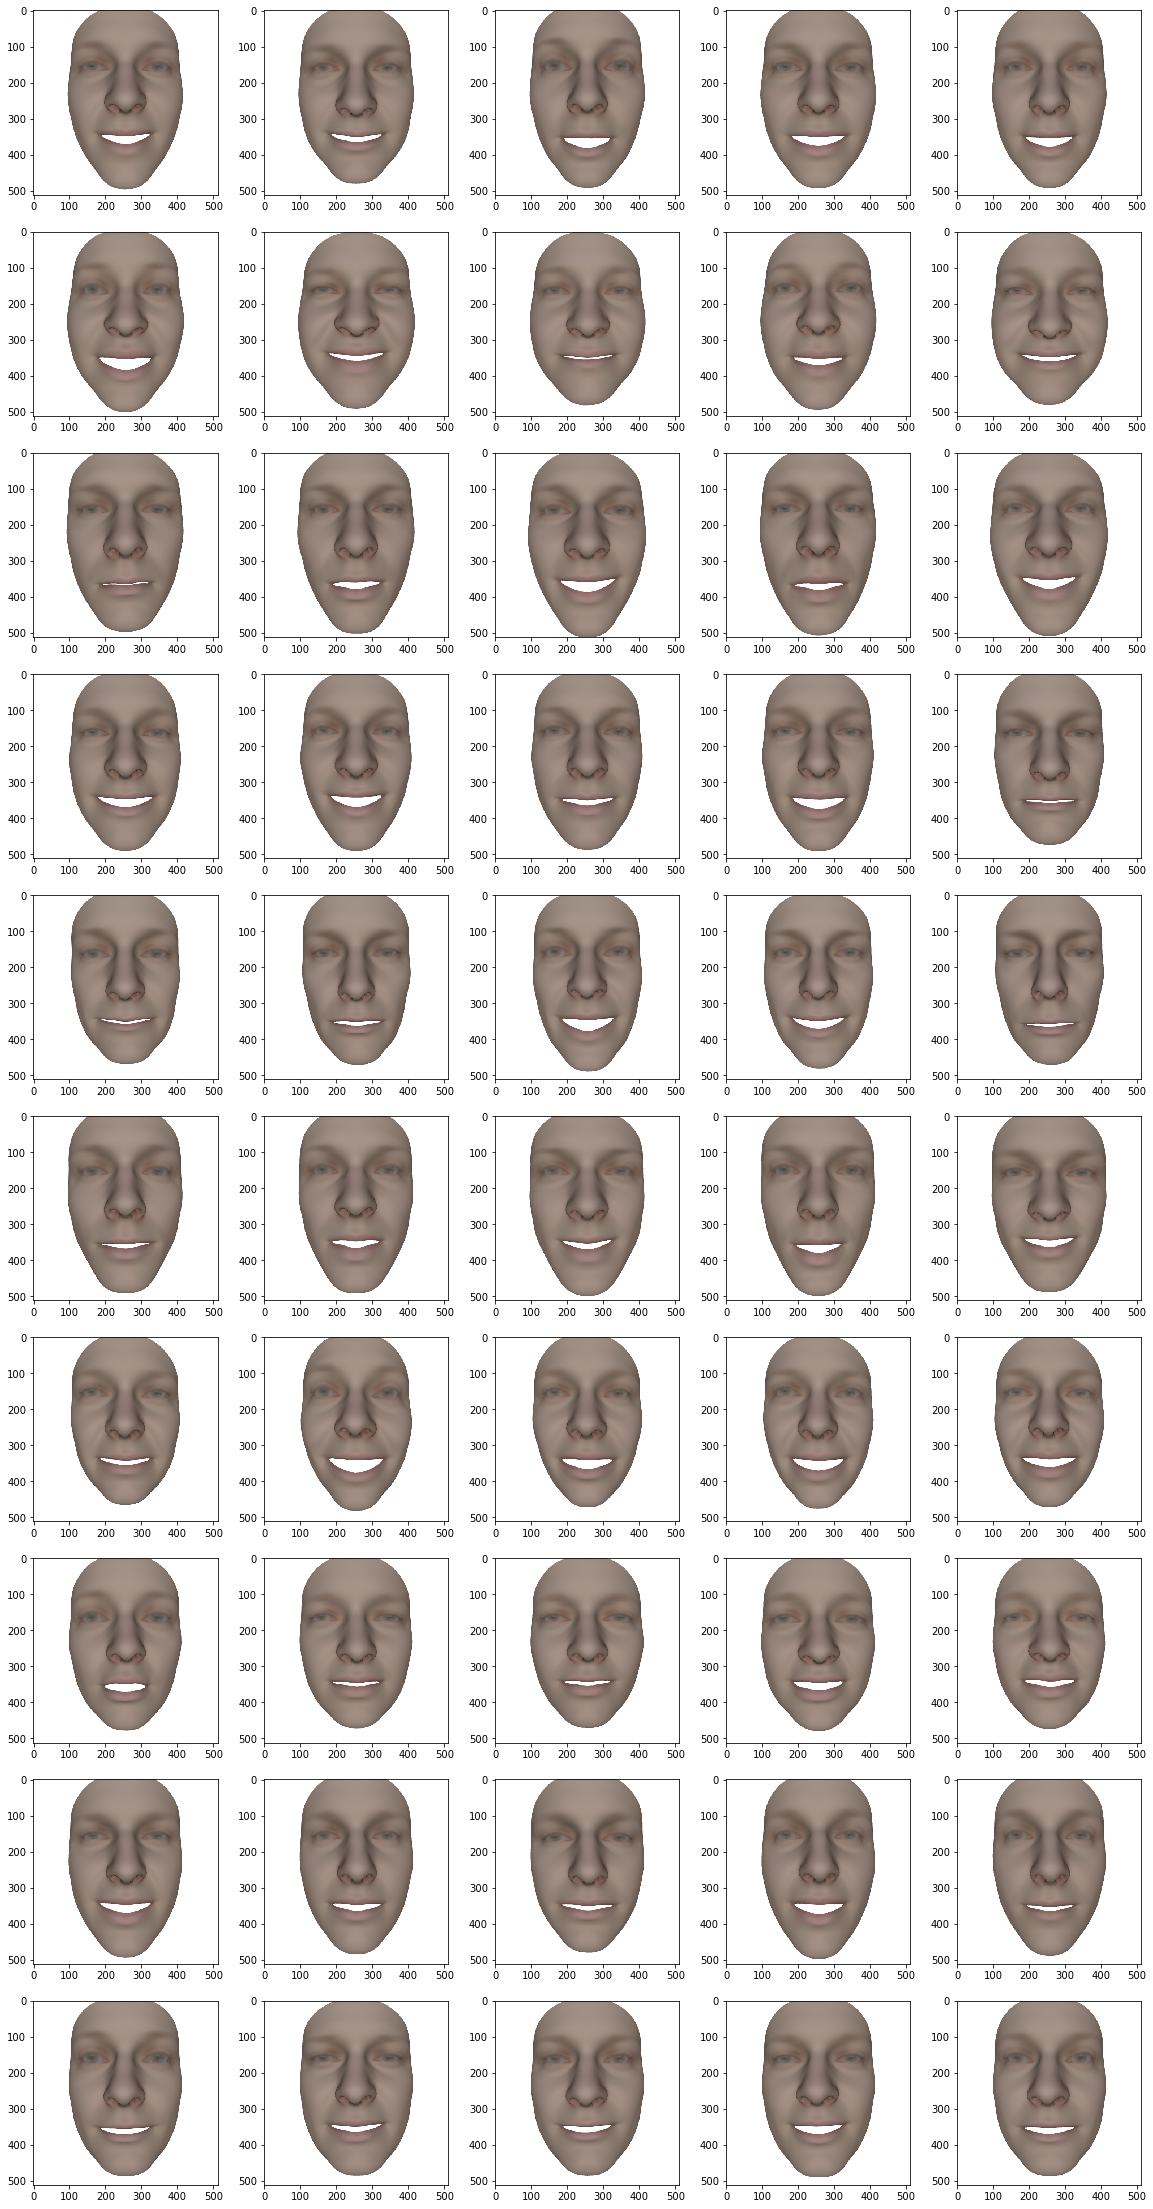

In [8]:
new_face = lambda alpha, beta: mean_shape + mean_expr \
           + basis_shape @ (alpha * np.sqrt(sigma2_shape)) \
           + basis_expr @ (beta * np.sqrt(sigma2_expr))

NCOLS=5
NROWS=10

%matplotlib inline
plt.figure(figsize=(20, 40))
alpha = 0
for i in range(NCOLS * NROWS):
    plt.subplot(NROWS, NCOLS, i + 1)
    if i > 0 and i % NCOLS == 0:
        alpha = np.random.uniform(-1, 1, 30)
    delta = np.random.uniform(-1, 1, 20)
    mesh = trimesh.base.Trimesh(
        vertices=new_face(alpha, delta), 
        faces=triangles, 
        vertex_colors=mean_tex
    )
    color, depth = render_mesh(mesh)
    plt.imshow(color)

plt.savefig("sampled_faces.png")
plt.show()


# Pinhole camera model

## Question 2

In [45]:
from collections import namedtuple


class ViewportMatrix(np.ndarray):
    """Assumes the order of the coordinates to be X, Y, Z
    Where Y is the height and Z the depth.
    """

    def __new__(cls, l=-1, r=1, t=1, b=-1):
        m = np.zeros((4, 4))
        m += np.diag(((r - l) / 2, (t - b) / 2, 0.5, 1))
        m[3, :3] = ((r + l) / 2, (t + b) / 2, 0.5)
        return m.view(cls)


class PerspectiveMatrix(np.ndarray):
    """Assumes the order of the coordinates to be X, Y, Z"""
    FOV_SETTINGS = namedtuple(
        'FovSettings', 
        'top bottom left right near far'
    )
    DEFAULT_FOV = FOV_SETTINGS(1, -1, 1, -1, 9.9, 10)
    
    def __new__(cls, *args, **kwargs):
        return np.zeros((4, 4)).view(cls)

    def __init__(self, fov=(1, -1, 1, -1, 9.9, 10)):
        fov = self.FOV_SETTINGS(*fov)

        # Build the perspective proj matrix
        self[0, 0] = 2 * fov.near / (fov.right - fov.left)
        self[0, 2] = (fov.right + fov.left) / (fov.right - fov.left)
        
        self[1, 1] = 2 * fov.near / (fov.top - fov.bottom)
        self[1, 2] = (fov.top + fov.bottom) / (fov.top - fov.bottom)
        
        self[2, 2] = - (fov.far + fov.near) / (fov.far - fov.near)
        self[2, 3] = - 2 * fov.far * fov.near / (fov.far - fov.near)
        self[3, 2] = -1


class TransformationMatrix(np.ndarray):
    """Assumes the order of the coordinates to be X, Y, Z"""
    def __new__(cls):
        return np.eye(4).view(cls)

    def reset(self):
        self[:] = np.eye(4)

    def translate(self, point):
        self[0:3, 3] += np.array(point)
    
    def rotate_y(self, angle):
        angle = angle * np.pi / 180 
        rot = np.array((
            (np.cos(angle), 0, np.sin(angle)),
            (0, 1, 0),
            (-np.sin(angle), 0, np.cos(angle))
        ))
        self[0:3, 0:3] = self[:3, :3] @ rot
        

def normalize_points(points, given_min_max=None):
    npoints = points.shape[0]
    norm_points = np.zeros((0, npoints))

    if given_min_max is None:
        min_max = []
        for i in np.arange(points.shape[1]):
            _min, _max = np.min(points[:, i]), np.max(points[:, i])
            norm_coords = (points[:, i] - _min) / (_max - _min)
            norm_points = np.append(norm_points, norm_coords.reshape((1, npoints)), axis=0)
            min_max.append((_min, _max))

        return norm_points.T, min_max

    else:
        for i in np.arange(points.shape[1]):
            _min, _max = given_min_max[i]
            norm_coords = (points[:, i] - _min) / (_max - _min)
            norm_points = np.append(norm_points, norm_coords.reshape((1, npoints)), axis=0)

        return norm_points.T, given_min_max


def denormalize_points(points, min_max):
    npoints = points.shape[0]
    denorm_points = np.zeros((0, npoints))

    for i in np.arange(points.shape[1]):
        _min, _max = min_max[i]
        norm_coords = points[:, i] * (_max - _min) + _min
        denorm_points = np.append(denorm_points, norm_coords.reshape((1, npoints)), axis=0)

    return denorm_points.T


def projection_new(S_p):
    # P = PerspectiveMatrix((1, -1, 1, -1, n, 100))
    T = TransformationMatrix()
    T.translate((0, 0, -500))
    P = PerspectiveMatrix((1, -1, 1, -1, 10, 20))
    V = ViewportMatrix()
    
#     print("Matrices")
#     print("V", V.shape)
#     print("P", P.shape)
#     print("T", T.shape)
    
#     Test = np.eye(4)
#     print(Test)
#     Test[:, 3] = [10, 10, 10, 1]
    
    print("POINTS")
    print(S_p.shape)
#     p = P @ T @ S_p.T
    p = P @ T @ S_p.T
    
    print(p.shape)
    
    # Convert homogeneous
    p = p / p[3, :]
    p = V @ p
#     p = p[:2, :]
    
    print(p.shape)
    
    return p.T


def projection(S, d=-500, near=10, far=20, yrot=0):
    T = TransformationMatrix()
#     T.rotate_y(yrot)
    T.translate((0, 0, d))
    P = PerspectiveMatrix((1, -1, 1, -1, near, far))
    V = ViewportMatrix()
    
    print(S)
    
    p = P @ T @ S    
    
    # Convert homogeneous
    p = p / p[3, :]
    p = V @ p
    p = p[:2, :]
    return p


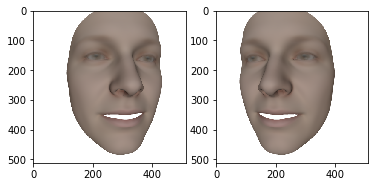

In [46]:
def get_rot_mat_y(angle):  
    angle = angle * np.pi / 180 
    m = np.eye(4)
    m[:3, :3] = np.array((
         (np.cos(angle), 0, np.sin(angle)),
         (0, 1, 0),
         (-np.sin(angle), 0, np.cos(angle))
    ))
    return m

mesh = trimesh.base.Trimesh(
    vertices=new_face(0, 0), 
    faces=triangles, 
    vertex_colors=mean_tex
)

points = mesh.vertices.T
ncoords, npoints = points.shape
S = np.vstack((points, np.ones(npoints)))



plt.subplot(1, 2, 1)
mesh.vertices = (get_rot_mat_y(10) @ S)[:3].T
color, depth = render_mesh(mesh)
plt.imshow(color)

plt.subplot(1, 2, 2)
mesh.vertices = (get_rot_mat_y(-10) @ S)[:3].T
color, depth = render_mesh(mesh)
plt.imshow(color)
plt.show()

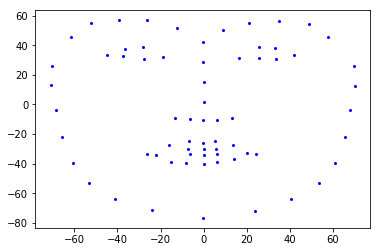

(68, 4)
[[0.00344215 0.76920193 0.05412333 1.        ]
 [0.         0.67401415 0.01092089 1.        ]
 [0.0181626  0.54512084 0.         1.        ]
 [0.03740584 0.41011664 0.01772683 1.        ]
 [0.07239056 0.27601984 0.06687418 1.        ]
 [0.12659656 0.17742266 0.13853222 1.        ]
 [0.21225831 0.09451043 0.28636244 1.        ]
 [0.33366099 0.03823651 0.5308404  1.        ]
 [0.50246513 0.         0.62585688 1.        ]
 [0.67173851 0.03653025 0.5334329  1.        ]
 [0.79162937 0.09403114 0.29800862 1.        ]
 [0.88114011 0.1776128  0.133439   1.        ]
 [0.93418854 0.27680188 0.06300785 1.        ]
 [0.96652126 0.40806171 0.01867244 1.        ]
 [0.98378611 0.5445314  0.00391945 1.        ]
 [1.         0.66759664 0.01321307 1.        ]
 [0.99581736 0.7699551  0.05426545 1.        ]
 [0.06575103 0.91334939 0.29620788 1.        ]
 [0.13185595 0.984815   0.50332797 1.        ]
 [0.22361778 0.9993031  0.63690674 1.        ]
 [0.3160581  1.         0.70683581 1.        ]
 [0.4

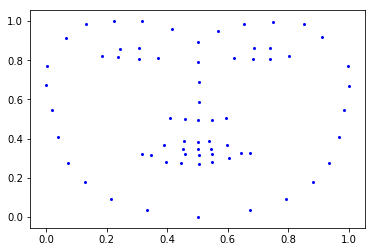

[[0.00344215 0.         0.0181626  0.03740584 0.07239056 0.12659656
  0.21225831 0.33366099 0.50246513 0.67173851 0.79162937 0.88114011
  0.93418854 0.96652126 0.98378611 1.         0.99581736 0.06575103
  0.13185595 0.22361778 0.3160581  0.41507879 0.56668329 0.65208024
  0.75016099 0.85023904 0.91078877 0.50135148 0.50197536 0.50312907
  0.50383323 0.40894768 0.45673329 0.50234348 0.54772544 0.59492952
  0.18484218 0.24347806 0.30497214 0.37015092 0.3077617  0.23846228
  0.61912489 0.68582296 0.73794401 0.80138767 0.74060941 0.68393397
  0.31644711 0.38996932 0.45541856 0.50251752 0.53928369 0.59853071
  0.67482334 0.60397553 0.54765111 0.50316411 0.44558266 0.39716756
  0.34503973 0.45301566 0.50281656 0.54496437 0.64438844 0.54849011
  0.50302261 0.45772153]
 [0.76920193 0.67401415 0.54512084 0.41011664 0.27601984 0.17742266
  0.09451043 0.03823651 0.         0.03653025 0.09403114 0.1776128
  0.27680188 0.40806171 0.5445314  0.66759664 0.7699551  0.91334939
  0.984815   0.9993031  

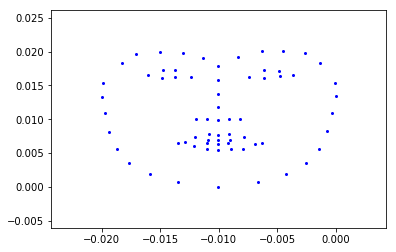

In [47]:
points = mean_shape_fland
npoints, ncoords = points.shape

x_1, y_1 = points[:, 0], points[:, 1]
plt.scatter(x_1, y_1, color="b", s=4)
plt.show()

points_norm, min_max = normalize_points(points)

S_norm = np.hstack((points_norm, np.ones(npoints).reshape(-1, 1)))
print(S_norm.shape)
print(S_norm)

x_1, y_1 = S_norm[:, 0], S_norm[:, 1]
plt.scatter(x_1, y_1, color="b", s=4)
plt.show()

# p = projection(S_norm.T, d=-500, near=10, far=20, yrot=0)
p = projection(S_norm.T)
# p = projection_new(S_norm)

x_1, y_1 = p[0, :], p[1, :]
plt.scatter(x_1, y_1, color="b", s=4)
plt.show()

# fig = plt.figure()
# ax = fig.add_subplot(1, 1, 1)
# c = ax.scatter(*p, s=1)

# # Annotate
# for i in range(len(fland)):
#     ax.annotate(str(i), (p[0][i], p[1][i]))


# plt.ylim((-1, 1))
# plt.xlim((-1, 1))
# #plt.axis('equal')
# plt.show()

# Breakdown 4

In [10]:
npoints = len(fland)
n_whole_points = mean_shape.shape[0]

points = mean_shape_fland + mean_expr_fland

points_norm, min_max_points = normalize_points(points)
S = np.concatenate((points_norm, np.ones((npoints, 1))), axis=1)

whole_points = mean_shape + mean_expr
whole_points_norm, min_max_w_points = normalize_points(whole_points)
whole_S = np.concatenate((whole_points_norm, np.ones((n_whole_points, 1))), axis=1)

In [11]:
# Loading the target image
img = dlib.load_rgb_image("faces/dan.jpg")
# img = dlib.load_rgb_image("faces/surprise.png")

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("Data/shape_predictor_68_face_landmarks.dat")
dets = detector(img, 1)
ground_truth = np.array([(point.x, point.y) for point in predictor(img, dets[0]).parts()])
norm_ground_truth, min_max_gt = normalize_points(ground_truth)


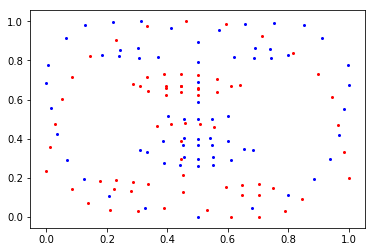

In [12]:
x_1, y_1 = S[:, 0], S[:, 1]
x_2, y_2 = norm_ground_truth[:, 0], norm_ground_truth[:, 1]
plt.scatter(x_1, y_1, color="b", s=4)
plt.scatter(x_2, y_2, color="r", s=4)
plt.show()

In [13]:
_pred = denormalize_points(S[:, :3], min_max_points)
_gt = denormalize_points(norm_ground_truth, min_max_gt)

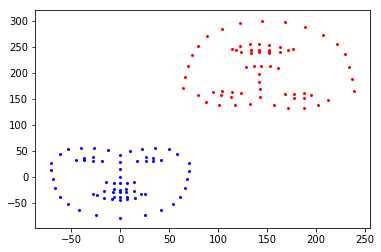

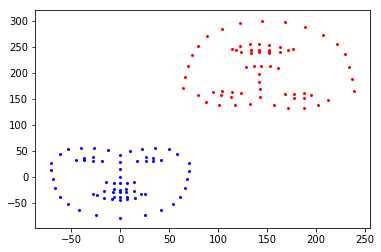

In [14]:
x_1, y_1 = points[:, 0], points[:, 1]
x_2, y_2 = ground_truth[:, 0], ground_truth[:, 1]
plt.scatter(x_1, y_1, color="b", s=4)
plt.scatter(x_2, y_2, color="r", s=4)
plt.show()

x_1, y_1 = _pred[:, 0], _pred[:, 1]
x_2, y_2 = _gt[:, 0], _gt[:, 1]
plt.scatter(x_1, y_1, color="b", s=4)
plt.scatter(x_2, y_2, color="r", s=4)
plt.show()

(68, 4)
[0.00404592 0.77840424 0.05695355 1.        ]


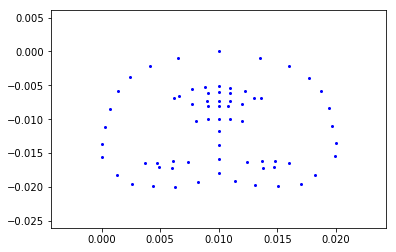

In [15]:
print(S.shape)
print(S[0])
p2d = projection(S.T)
p2d = p2d.T

x_1, y_1 = p2d[:, 0], p2d[:, 1]
# x_2, y_2 = S[:, 0], S[:, 1]
plt.scatter(x_1, y_1, color="b", s=4)
# plt.scatter(x_2, y_2, color="r", s=4)
plt.show()